In [1]:
# Define Backtest Parameters
# SHORTING NOT CURRENTLY IMPLEMENTED
# Let long_pos = 1.0 if backtesting long-only strategy
# Decimal value example: long_pos = .7 --> 70% long, 30% short
starting_cash = 1000000
long_pos = 1.0
long_port_path = 'top40Data.csv'
short_port_path = 'all_tickers_in_quandl_bottom_ex.csv'  # Only used if long_pos != 1.0

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

In [3]:
if long_pos == 1.0:
    shorting = False
else:
    shorting = True

In [4]:
# Load equity data
equity_data = pd.read_csv('equity_data.csv')

In [5]:
# Load portfolio data
long_port_data = pd.read_csv(long_port_path)
long_port_data['date'] = pd.to_datetime(long_port_data['dateMonth'], format='%Y%m')
long_traded_tickers = long_port_data['ticker'].unique().tolist()

if shorting:
    short_port_data = pd.read_csv(short_port_path)
    short_port_data['date'] = pd.to_datetime(short_port_data['dateMonth'], format='%Y%m')
    short_traded_tickers = short_port_data['ticker'].unique().tolist()

In [6]:
# Filter data to only keep tickers we trade to make things slightly faster
traded_tickers = list(set(long_traded_tickers))

if shorting:
    traded_tickers = list(set(long_traded_tickers + short_traded_tickers))

equity_data = equity_data[equity_data['ticker'].isin(traded_tickers)]

In [7]:
# Convert date column to datetime
equity_data['date'] = pd.to_datetime(equity_data['date'], format='%Y-%m-%d')

In [8]:
# Find the last trading day of each month
# Convert from np.datetime64 to pd.to_datetime to pull out attributes
equity_data_unique_dates = pd.to_datetime(equity_data['date'].unique()).sort_values()

# Figure out last trading day of month by comparing day of month
# e.g. if prev_day = 30 and cur_day = 1, we know we've reached a new month
last_trading_day_per_month = []
prev_day = equity_data_unique_dates[0].day
for ind, cur_date in enumerate(equity_data_unique_dates[1:]):
    if prev_day > cur_date.day:
        last_trading_day_per_month.append(equity_data_unique_dates[ind])
    prev_day = cur_date.day

# Create a list of datetimes where we go from last_trading_day_per_month
# (e.g. 1999-02-27 to something like 1999-02-01) to more easily find tickers
# on trading days
first_day_01_for_last_trading_day_per_month = [
    date.replace(day=1) for date in last_trading_day_per_month
]

# Change portfolio df date to trading date
long_port_data['date'] = long_port_data['date'].replace(
    first_day_01_for_last_trading_day_per_month, last_trading_day_per_month
)

if shorting:
    short_port_data['date'] = short_port_data['date'].replace(
        first_day_01_for_last_trading_day_per_month, last_trading_day_per_month
    )

In [9]:
# Align the dates we have both portfolio data and equity data for
# so that we don't try to find data for equities we don't have
# Don't assume that long_port dates match short_port dates because
# we've had mismatched portfolios before
equity_data_min_date = min(equity_data_unique_dates)
equity_data_max_date = max(equity_data_unique_dates)

long_port_data_unique_dates = pd.to_datetime(long_port_data['date'].unique()).tolist()
long_port_data_min_date = min(long_port_data_unique_dates)
long_port_data_max_date = max(long_port_data_unique_dates)

first_date = max([long_port_data_min_date, equity_data_min_date])
last_date = min([long_port_data_max_date, equity_data_max_date])

if shorting:
    short_port_data_unique_dates = pd.to_datetime(short_port_data['date'].unique()).tolist()
    short_port_data_min_date = min(short_port_data_unique_dates)
    short_port_data_max_date = max(short_port_data_unique_dates)
    first_date = max([long_port_data_min_date, short_port_data_min_date, equity_data_min_date])
    last_date = min([long_port_data_max_date, short_port_data_max_date, equity_data_max_date])

# Create masks and filter data
equity_data_date_mask = equity_data['date'].between(first_date, last_date)
equity_data = equity_data[equity_data_date_mask]

long_port_data_date_mask = long_port_data['date'].between(first_date, last_date)
long_port_data = long_port_data[long_port_data_date_mask]

if shorting:
    short_port_data_date_mask = short_port_data['date'].between(first_date, last_date)
    short_port_data = short_port_data[short_port_data_date_mask]

In [10]:
def calc_fees(num_shares, price):
    """
    Function that calculates fixed fees on IB for buying/selling securities
    Inputs:
        num_shares: float, if positive --> buying, if negative --> selling
        price: float, price per share
    Returns:
        total_fee, float
    """
    
    if num_shares > 0:
        trade_type = 'buy'
    else:
        trade_type = 'sell'
    
    trade_value = num_shares * price
    
    # IB Fee
    ib_fee = num_shares * 0.005
    ib_min_fee_per_order = 1.00  # USD
    ib_max_fee_per_order = 0.01 * trade_value
    if ib_fee < ib_min_fee_per_order:
        ib_fee = 1.0
    elif ib_fee > ib_max_fee_per_order:
        ib_fee = ib_max_fee_per_order

    # US Transaction Fees
    transaction_fees = 0
    if trade_type == 'sell':
        transaction_fees += 0.0000207 * trade_value
        # FINRA Trading Activity Fee (max of $5.95)
        transaction_fees += np.min([num_shares * 0.000119, 5.95])

    total_fee = ib_fee + transaction_fees

    return total_fee

In [11]:
def calc_rebalance(cur_port, new_port, cash):
    # Only need to keep number of shares, price and weight columns before join
    cur_port = cur_port[['num_shares', 'close', 'weights']]
    new_port = new_port[['num_shares', 'close', 'weights']]
    rebal_port = cur_port.join(new_port, how='outer', lsuffix='_old', rsuffix='')    
    rebal_port = rebal_port.fillna(0)
    rebal_port['change'] = rebal_port['num_shares'] - rebal_port['num_shares_old']
    rebal_port['fees'] = rebal_port.apply(
        lambda row: calc_fees(row['change'], row['close']), axis=1
    )
    fees = rebal_port['fees'].sum()
    
    # Let's figure out how much cash we end up with after entering/exiting the trades
    # Positive vol means we spent money, negative vol means we ended up with some extra money
    # If close column is 0, it's because we don't have a price because it's not in our
    # portfolio anymore so we don't get a new price from the join above
    # That's okay because the 'close_old' column is up-to-date
    rebal_port['close'] = np.where(
        rebal_port['close'] == 0, rebal_port['close_old'], rebal_port['close']
    )
    rebal_port['val'] = rebal_port['change'] * rebal_port['close']
    net_cash_spent_in_trades = rebal_port['val'].sum()
    
    # Need to trade cash worth of stocks to make sure we're not over or under invested
    # This means the fees we pay are slightly inaccurate
    # Let's trade the stock we have our highest weighting in to balance
    cash -= net_cash_spent_in_trades + fees
    cash_per_stock = cash / len(rebal_port)
    rebal_port['num_shares'] += cash_per_stock / rebal_port['close']
    
    # Cash leftover is 0 after rebalance
    cash = 0
    
    return cash, fees, rebal_port['num_shares']

In [12]:
# Main block for backtesting
# Create empty DataFrame for starting backtesting
cur_long_data = pd.DataFrame(columns=['ticker', 'num_shares', 'close', 'weights'])
# Reset cash
cash = starting_cash
# Starting portfolio value for going from weights to num shares is starting_cash
port_val = starting_cash

# Create a dfs of various trading statistics calculated daily
equity_data_dates = sorted(equity_data['date'].unique())
trading_stats = pd.DataFrame(index=equity_data_dates)

equity_data_date_grouped = equity_data.groupby('date')

for date, date_df in equity_data_date_grouped:
    todays_equity_data = equity_data[equity_data['date'] == date]
    
    # Set todays_equity_data index to ticker so that we can update our portfolio values
    todays_equity_data = todays_equity_data.set_index('ticker')
    cur_long_data.update(todays_equity_data)
    todays_equity_data = todays_equity_data.reset_index()
    
    # Rebalance
    if date in last_trading_day_per_month:
        # Gather data
        new_long_port_data = long_port_data[long_port_data['date'] == date].sort_values('ticker')
        new_long_tickers = new_long_port_data['ticker']
        new_tickers = list(set(new_long_tickers))
        
        # Merge to get all data for our portfolio
        new_long_data = new_long_port_data.merge(todays_equity_data, how='inner', on='ticker')
        
        # Begin calculating holding values
        new_long_data['val'] = new_long_data['weights'] * port_val
        new_long_data['num_shares'] = new_long_data['val'] / new_long_data['close']
        
        # Set ticker to index for updating closing price later with df.update()
        # and because I know join() on index works for sure when rebalancing
        new_long_data = new_long_data.set_index('ticker')
        
        # Now do buying and selling, incur trading fees
        cash, fees, new_long_data['num_shares'] = calc_rebalance(cur_long_data, new_long_data, cash)
        
        # Keep note of fees paid
        trading_stats.at[date, 'fees_paid'] = fees  
        
        # Set current long data for daily portfolio balance calculation
        cur_long_data = new_long_data
        
    # Let's calculate our portfolio's net worth
    cur_long_data['val'] = cur_long_data['num_shares'] * cur_long_data['close']
    port_val = cur_long_data['val'].sum()
    trading_stats.at[date, 'port_val'] = port_val

trading_stats['fees_paid'] = trading_stats['fees_paid'].fillna(0)

In [13]:
# Calculate dividend reinvested SPY data
spy = pd.read_csv('SP500_daily.csv')
spy['date'] = pd.to_datetime(spy['date'], format='%m/%d/%y')
long_port_data['date'] = pd.to_datetime(long_port_data['dateMonth'], format='%Y%m')
start_dt = trading_stats.head(1).index.to_pydatetime()[0]
end_dt = trading_stats.tail(1).index.to_pydatetime()[0]
spy_mask = spy['date'].between(start_dt, end_dt)
spy = spy[spy_mask]
spy['close_change'] = 1 + spy['close'].pct_change()
spy['dividend_div_close'] = spy['dividend'] / spy['close']
spy = spy.reset_index()

# Reinvest dividens to buy more shares
num_shares_list = np.zeros(len(spy))
for ind, row in spy.iterrows():
    if ind == 0:
        num_shares = starting_cash / row['close']
    if row['dividend'] > 0:
        num_shares += row['dividend'] / row['close']
    num_shares_list[ind] = num_shares

# Calculate growth with reinvested dividends
spy['num_shares'] = num_shares_list
spy['dividend_reinvested_growth'] = spy['num_shares'] * spy['close']
spy = spy.set_index('date')

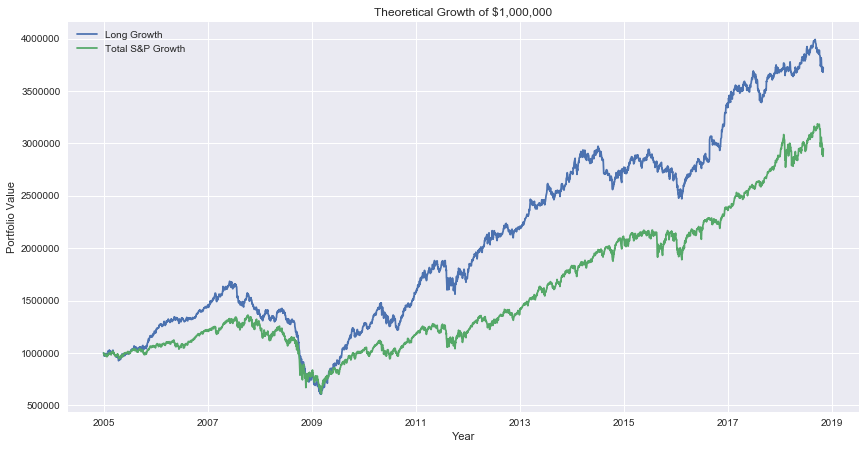

In [14]:
# Plot Portfolio Change over Time
plt.plot(trading_stats['port_val'], label='Long Growth')
plt.plot(spy['dividend_reinvested_growth'], label='Total S&P Growth')
plt.legend()
plt.tight_layout()
plt.title('Theoretical Growth of ${:,}'.format(starting_cash))
plt.xlabel('Year')
plt.ylabel('Portfolio Value')
plt.show()

In [15]:
# Parse the Treasury Rate
treasury_rate = pd.read_csv('DGS10_1962_2019.csv')
treasury_rate.columns = ['date', 'treasury_10y']
treasury_rate['date'] = pd.to_datetime(treasury_rate['date'], format='%Y-%m-%d')
treasury_rate = treasury_rate.set_index('date')
trading_stats = trading_stats.join(treasury_rate)
trading_stats['treasury_10y'] = trading_stats['treasury_10y'].fillna(method='ffill')

In [16]:
# Rolling Sharpe Ratio Calculation
trading_stats['returns_1y'] = trading_stats['port_val'].pct_change(252) * 100
trading_stats['excess_returns_1y'] = trading_stats['returns_1y'] - trading_stats['treasury_10y']
excess_returns_1y_std = trading_stats['excess_returns_1y'].std()
trading_stats['rolling_sharpe_1y'] = trading_stats['excess_returns_1y'] / excess_returns_1y_std
sharpe_ratio = trading_stats['rolling_sharpe_1y'].mean()
print('Sharpe Ratio (1y Mean): {:.3f}'.format(sharpe_ratio))

Sharpe Ratio (1y Mean): 0.437


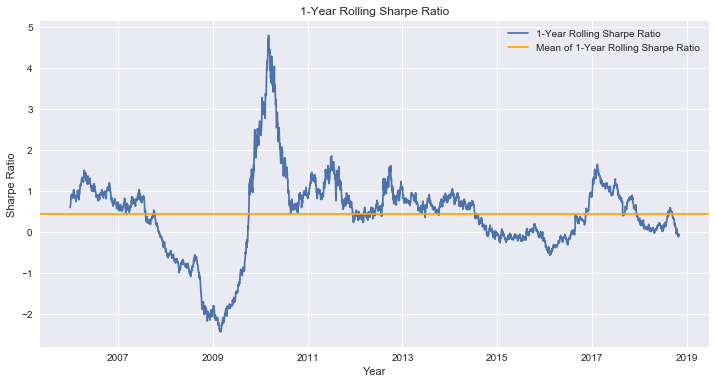

In [17]:
# Rolling Sharpe Ratio Plotting
plt.plot(trading_stats['rolling_sharpe_1y'], label='1-Year Rolling Sharpe Ratio')
plt.axhline(sharpe_ratio, color='orange', label='Mean of 1-Year Rolling Sharpe Ratio')
plt.legend()
plt.title('1-Year Rolling Sharpe Ratio')
plt.xlabel('Year')
plt.ylabel('Sharpe Ratio')
plt.show()

In [18]:
# Rolling Sortino Ratio Calculation
sortino_mask = trading_stats['excess_returns_1y'] < 0
excess_returns_1y_std_neg = trading_stats['excess_returns_1y'][sortino_mask].std()
trading_stats['rolling_sortino_1y'] = trading_stats['excess_returns_1y'] / excess_returns_1y_std_neg
sortino_ratio = trading_stats['rolling_sortino_1y'].mean()
print('Sortino Ratio (1y Mean): {:.3f}'.format(sortino_ratio))

Sortino Ratio (1y Mean): 0.608


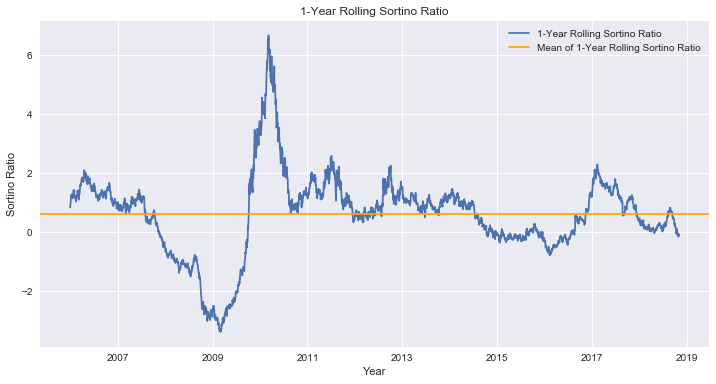

In [19]:
# Rolling Sortino Ratio Plotting
plt.plot(trading_stats['rolling_sortino_1y'], label='1-Year Rolling Sortino Ratio')
plt.axhline(sortino_ratio, color='orange', label='Mean of 1-Year Rolling Sortino Ratio')
plt.legend()
plt.title('1-Year Rolling Sortino Ratio')
plt.xlabel('Year')
plt.ylabel('Sortino Ratio')
plt.show()

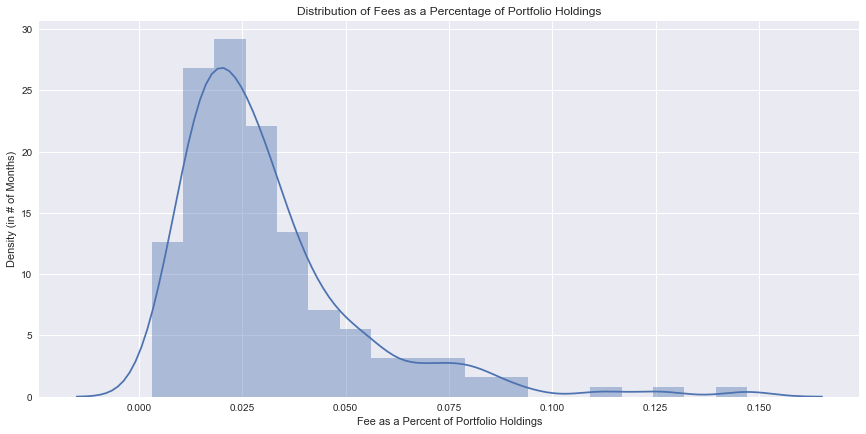

In [20]:
# Calculate and Plot Fee as a Fraction of Portfolio Holdings 
trading_stats['fee_pct'] = 100 * (trading_stats['fees_paid'] / (trading_stats['fees_paid'] + trading_stats['port_val']))
fee_pcts = trading_stats['fee_pct'][trading_stats['fee_pct'] != 0]
sns.distplot(fee_pcts)
plt.tight_layout()
plt.title('Distribution of Fees as a Percentage of Portfolio Holdings')
plt.xlabel('Fee as a Percent of Portfolio Holdings')
plt.ylabel('Density (in # of Months)')
plt.show()

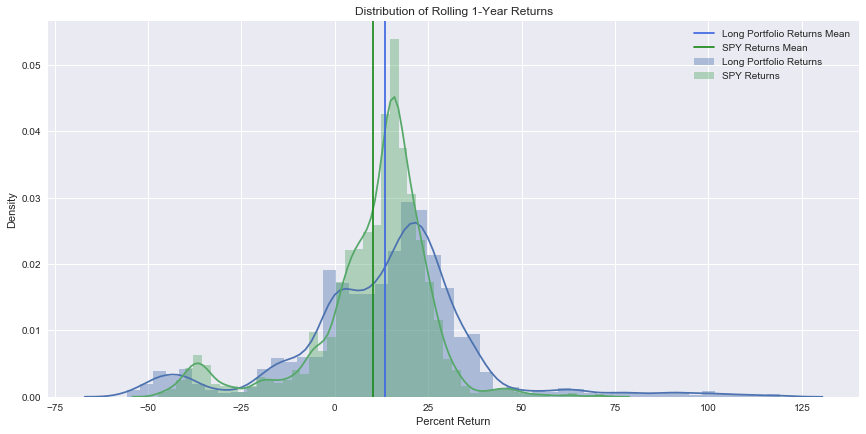

In [21]:
# Let's see the distribution of returns for our portfolio and SPY
spy['returns_1y'] = spy['dividend_reinvested_growth'].pct_change(252) * 100
long_port_rets = trading_stats['returns_1y'][~np.isnan(trading_stats['returns_1y'])]
spy_rets = spy['returns_1y'][~np.isnan(spy['returns_1y'])]
sns.distplot(long_port_rets, label='Long Portfolio Returns')
sns.distplot(spy_rets, label='SPY Returns')
plt.axvline(long_port_rets.mean(), color='royalblue', label='Long Portfolio Returns Mean')
plt.axvline(spy_rets.mean(), color='forestgreen', label='SPY Returns Mean')
plt.legend()
plt.tight_layout()
plt.title('Distribution of Rolling 1-Year Returns')
plt.xlabel('Percent Return')
plt.ylabel('Density')
plt.show()

In [22]:
# Calculate Alpha, Beta
beta, alpha, r_value, p_value, std_err = stats.linregress(
    spy['dividend_reinvested_growth'] / starting_cash, 
    trading_stats['port_val'] / starting_cash
)
print('Alpha: {:.3f}'.format(alpha))
print('Beta:  {:.3f}'.format(beta))

Alpha: -0.111
Beta:  1.392


In [23]:
# Calculate Annualized Return
profit = (trading_stats['port_val'][-1] - trading_stats['port_val'][0]) / trading_stats['port_val'][0]
num_years = (end_dt - start_dt).days / 365.25
annualized_return = (((1 + profit) ** (1 / num_years)) - 1) * 100
print('Annualized Return: {:.3f}%'.format(annualized_return))

Annualized Return: 9.965%


In [24]:
# trading_stats.to_csv('trading_stats.csv')

In [25]:
trading_stats

,fees_paid,port_val,treasury_10y,returns_1y,excess_returns_1y,rolling_sharpe_1y,rolling_sortino_1y,fee_pct
2004-12-31,322.045207,9.996780e+05,4.24,NaN,NaN,NaN,NaN,0.032205
2005-01-03,0.000000,9.850282e+05,4.23,NaN,NaN,NaN,NaN,0.000000
2005-01-04,0.000000,9.768732e+05,4.29,NaN,NaN,NaN,NaN,0.000000
2005-01-05,0.000000,9.698197e+05,4.29,NaN,NaN,NaN,NaN,0.000000
2005-01-06,0.000000,9.760459e+05,4.29,NaN,NaN,NaN,NaN,0.000000
2005-01-07,0.000000,9.759077e+05,4.29,NaN,NaN,NaN,NaN,0.000000
2005-01-10,0.000000,9.800025e+05,4.29,NaN,NaN,NaN,NaN,0.000000
2005-01-11,0.000000,9.803785e+05,4.26,NaN,NaN,NaN,NaN,0.000000
2005-01-12,0.000000,9.777645e+05,4.25,NaN,NaN,NaN,NaN,0.000000
2005-01-13,0.000000,9.746802e+05,4.20,NaN,NaN,NaN,NaN,0.000000
